# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

Жесткий дедлайн: 26.11.2023

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings('ignore')

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [88]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [89]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: Поскольку это случайный классификатор, то вероятности 0.5 означают, что случайная модель будет равноверотяно выбирать к какому классу отнести объект, таким образом не учитывая данные

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [90]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


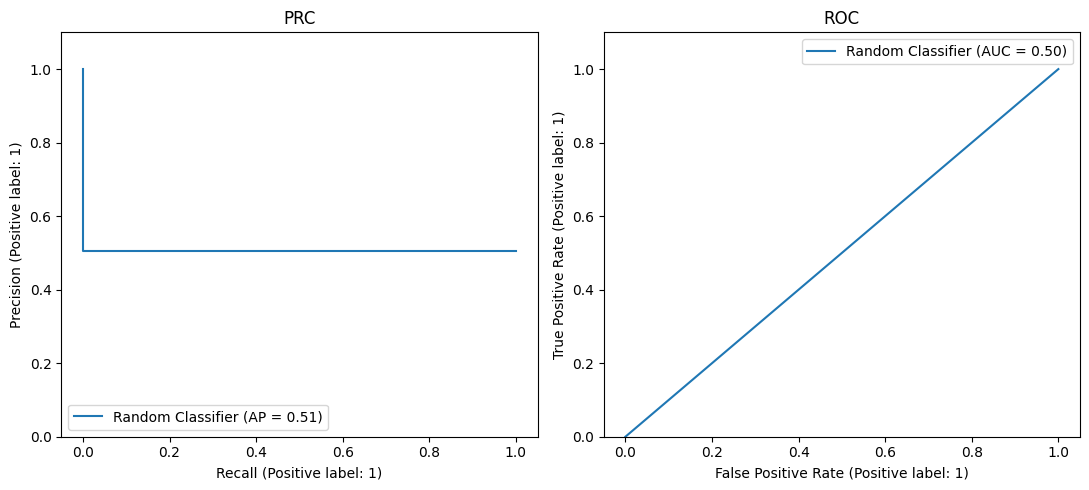

In [91]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [92]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [93]:
from sklearn.svm import LinearSVC

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

C_s = np.logspace(-10, 1, 10)

auc_pr_max = 0
best_c = 0
roc_auc_for_best = 0

for c in C_s:

    svc = LinearSVC(max_iter=100000, C=c).fit(X_train, y_train)
    svc_pred = svc.decision_function(X_val)

    precision, recall, _ = precision_recall_curve(y_val, svc_pred)

    auc_score = auc(recall, precision)
    roc_aucc = roc_auc_score(y_val, svc_pred)

    if auc_score > auc_pr_max:

        auc_pr_max = auc_score
        best_c = c
        roc_auc_for_best = roc_aucc


print(f'MAX AUC-PR: {auc_pr_max}', '\n', f'Best C: {best_c}')

MAX AUC-PR: 0.8147080550258909 
 Best C: 7.742636826811277e-06


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

SVM metrics
AUC-PR: 0.82341
AUC-ROC: 0.84004


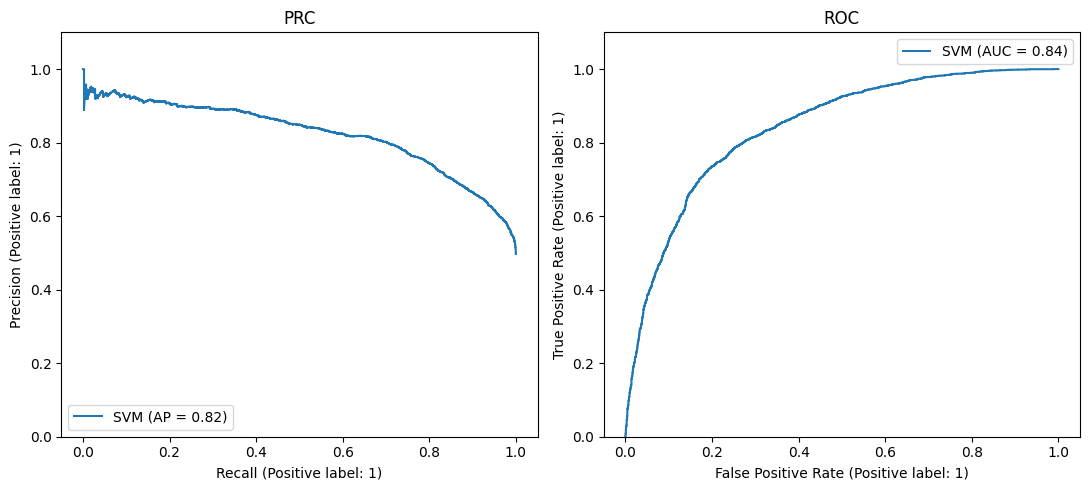

In [94]:
svc = LinearSVC(max_iter=100000, C=best_c).fit(X_train, y_train)
depict_pr_roc(y_train, svc.decision_function(X_train), 'SVM')

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [95]:
df_metrics.loc['Linear SVM'] = [
      auc_pr_max,
      roc_auc_for_best,
      best_c
]
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.000000
Linear SVM,0.814708,0.831284,0.000008


__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



LogReg metrics
AUC-PR: 0.81757
AUC-ROC: 0.83349


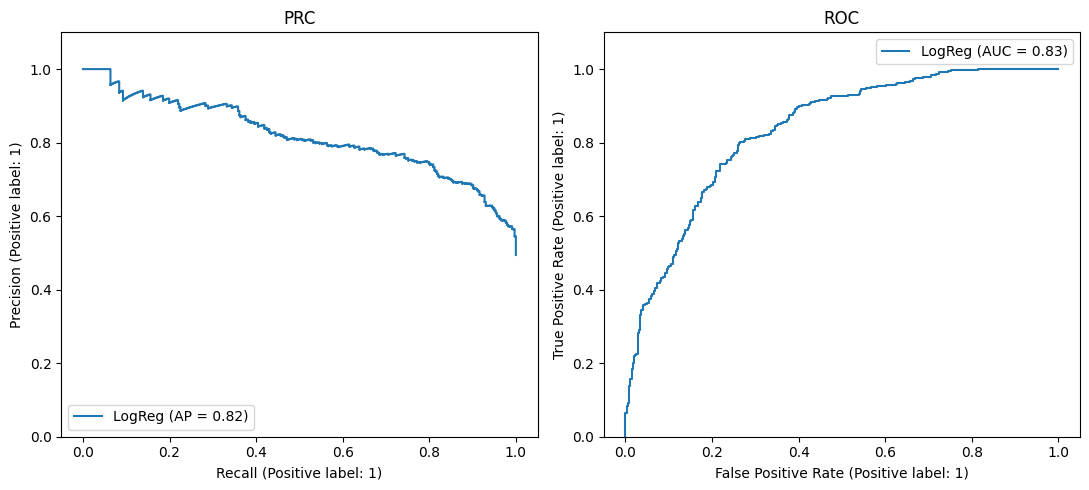

In [96]:
from sklearn.linear_model import LogisticRegression

C_s = np.logspace(-10, 1, 10)

auc_pr_max = 0
best_c = 0
roc_auc_for_best = 0
best_pred_log_reg = None

for c in C_s:

    logreg = LogisticRegression(penalty='l2',C=c).fit(X_train, y_train)
    logreg_pred = logreg.predict_proba(X_val)[:, 1]

    precision, recall, _ = precision_recall_curve(y_val, logreg_pred)

    auc_score = auc(recall, precision)
    roc_aucc = roc_auc_score(y_val, logreg_pred)

    if auc_score > auc_pr_max:

        auc_pr_max = auc_score
        best_c = c
        roc_auc_for_best = roc_aucc
        best_pred_log_reg = logreg_pred


depict_pr_roc(y_val, best_pred_log_reg, 'LogReg')

In [97]:
df_metrics.loc['LogReg'] = [
      auc_pr_max,
      roc_auc_for_best,
      best_c
]
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.000000
Linear SVM,0.814708,0.831284,0.000008
LogReg,0.817574,0.833488,0.000129


Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

SVM metrics
AUC-PR: 0.82341
AUC-ROC: 0.84004
LogReg metrics
AUC-PR: 0.82280
AUC-ROC: 0.85217
Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


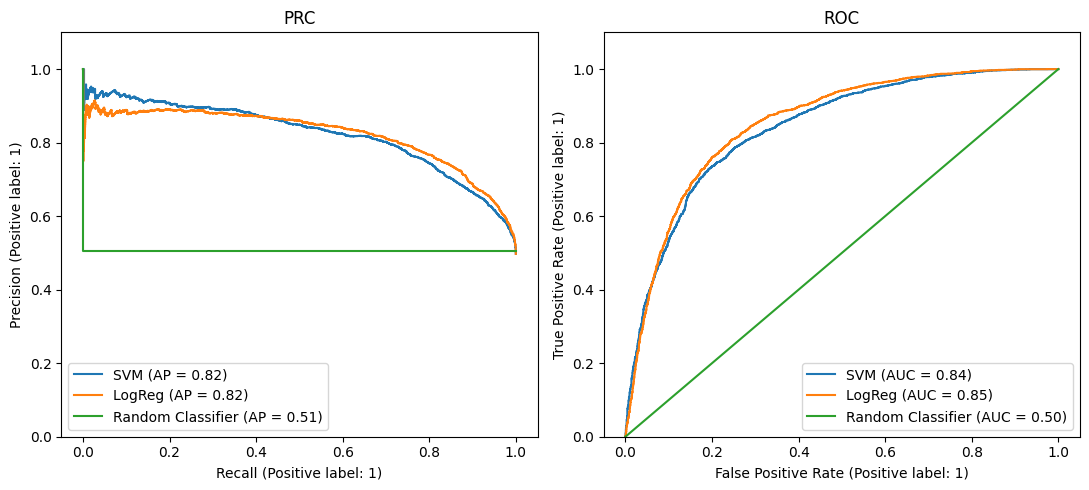

In [98]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

depict_pr_roc(y_train, svc.decision_function(X_train), 'SVM', ax=ax)
depict_pr_roc(y_train, logreg.decision_function(X_train), 'LogReg', ax=ax)
depict_pr_roc(y_test, y_random, 'Random Classifier', ax=ax)

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** Качества <code>LogReg</code> и <code>SVM</code> практически идентичны, различия минимальны

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [99]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC

data_x, data_y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=10)

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y, random_state=1)

model = SVC(kernel='linear', random_state=5).fit(X_train, y_train)


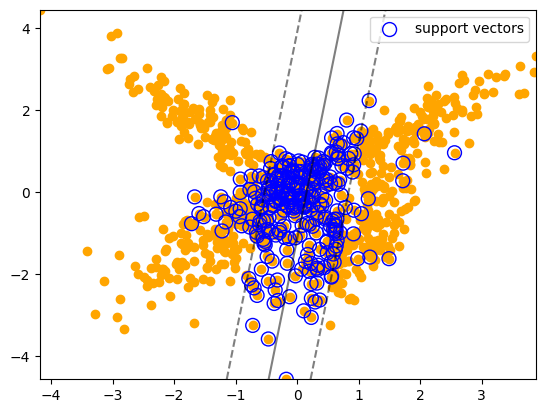

In [100]:
def plot_svm_2D(X, y, model,  plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], color='orange')

    #Отрисовали опорные векторы
    if plot_support:
        plt.scatter(
                   model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   label='support vectors',
                   s=100,
                   linewidth=1,
                   edgecolor="blue",
                   facecolors='none')

    plt.legend()

plot_svm_2D(X_train, y_train, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** В основном опорными объектами являются элементы, которые находятся в рамках опорных векторов, т.е. определяют положение, где они должны находиться на графике

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

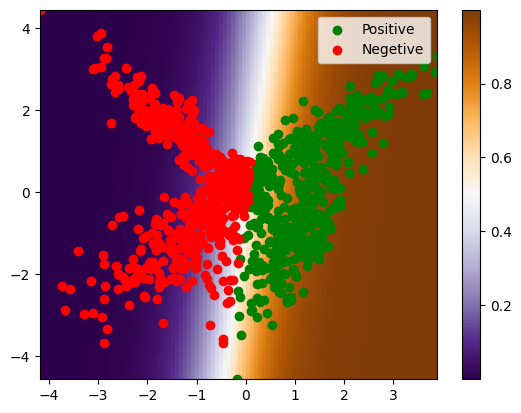

In [101]:
log_reg = LogisticRegression(random_state=5).fit(X_train, y_train)

def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1]
    Z = Z.reshape((xx.shape[0], -1)).T

    pred = model.predict(data_x)

    positive_1 = data_x[(pred == 1), 0]
    positive_2 = data_x[(pred == 1), 1]

    negative_1 = data_x[(pred == 0), 0]
    negative_2 = data_x[(pred == 0), 1]



    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    plt.scatter(positive_1, positive_2, cmap=plt.cm.Paired, color='green', label='Positive')
    plt.scatter(negative_1, negative_2, cmap=plt.cm.Paired, color='red', label='Negetive')

    plt.legend()

    plt.colorbar(image)


plot_logreg_2D(X_train, y_train, log_reg)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** На графике есть область, выделенная белым цветом, где модель неуверена в своих предсказаниях. Также по шкале видно, что белым цветом обозначена вероятность 0.5, что подтверждает вышесказанное суждение 

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [102]:
def plot_calibration_curve(y_test, preds, ax=None, label = ''):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)

        ### Ошибка №1: поменять - на +
        bin_middle_points.append((l + r) / 2)

        ### Ошибка №2: заменить min на mean
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    ax.plot(bin_middle_points, bin_real_ratios, label=label)
    ax.set_ylim([-0.05, 1.05])
    ax.grid()


Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

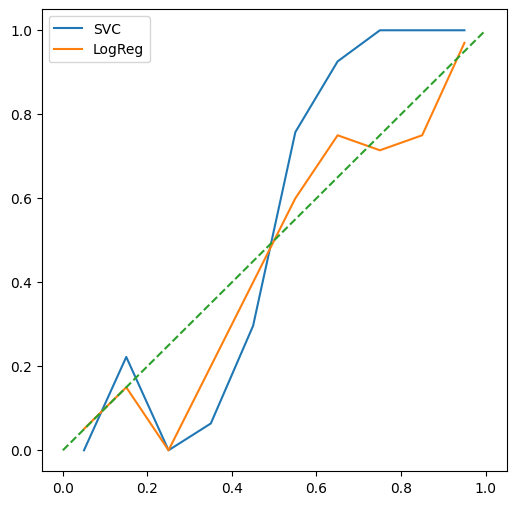

In [103]:
data_x, data_y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=5)

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y, random_state=1)

model_1 = SVC(kernel='linear', probability=True, random_state=10).fit(X_train, y_train)
model_2 = LogisticRegression(random_state=10).fit(X_train, y_train)


fig, ax = plt.subplots(1, 1, figsize=(6, 6))

pred_svc = model_1.decision_function(X_test)
pred_svc = (pred_svc - pred_svc.min()) / (pred_svc.max() - pred_svc.min())

plot_calibration_curve(y_test, pred_svc, ax, 'SVC')
plot_calibration_curve(y_test, model_2.predict_proba(X_test)[:, 1], ax, 'LogReg')
ax.plot([0, 1], [0,1], linestyle='--')
plt.legend();


**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** На графике видно, что <code>SVM</code> и <code>LogReg</code> сильно колеблются вокруг диагонали (идеальной калибровочной прямой), поэтому стоит получше откалибровать вероятности у <code>SVM</code> и <code>LogReg</code>

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

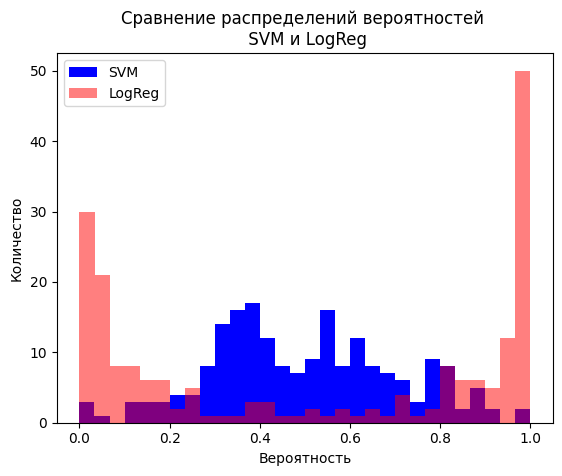

In [104]:
plt.hist(pred_svc, bins=30, color='blue', label='SVM')
plt.hist(model_2.predict_proba(X_test)[:, 1], bins=30, alpha=0.5, color='red', label='LogReg')
plt.xlabel('Вероятность')
plt.ylabel('Количество')
plt.title('Сравнение распределений вероятностей \n SVM и LogReg')
plt.legend();


**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** У <code>SVM</code> и <code>LogReg</code> разные функции потерь, от чего может следовать такие различия. Также <code>SVM</code> основывается на нахождении оптимальной гиперплокости и не учитывает данные, а <code>LogReg</code> основывается на гипотезе о бинарном распределении

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

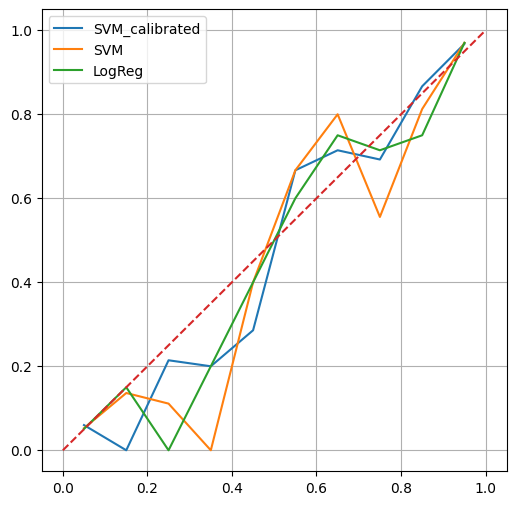

In [105]:
from sklearn.calibration import CalibratedClassifierCV


svm_calibrated = CalibratedClassifierCV(model_1, cv=10)

svm_calibrated.fit(X_train, y_train)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))


plot_calibration_curve(y_test, svm_calibrated.predict_proba(X_test)[:, 1], ax, 'SVM_calibrated')
plot_calibration_curve(y_test, model_1.predict_proba(X_test)[:, 1], ax, 'SVM')
plot_calibration_curve(y_test, model_2.predict_proba(X_test)[:, 1], ax, 'LogReg')
ax.plot([0, 1], [0,1], linestyle='--')
plt.legend();

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** Калибровочная кривая для <code>SVM</code> действительно улучшилась, поскольку уменьшились колебания вокруг диагонали

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

<center>

### Калибровка вероятностей Платта 

</center>

#### Формула выглядит следующим образом:

### $$ \mathbb{P}(y_i = +1 | x_i) = \sigma(aq(x_i) + b) = \frac{1}{1 + e^{-aq(x_i) - b}} $$

#### Где $ q(x_i) $ - предсказанная вероятность 

<br>

#### Стоит подобрать параметры $ a $ и $ b $ с помощью метода максимального правдоподобия $ \Rightarrow $ следует использовать логистическую регрессию для подбора этих параметров (т.к. в основе тоже лежит метод максимального правдоподобия )

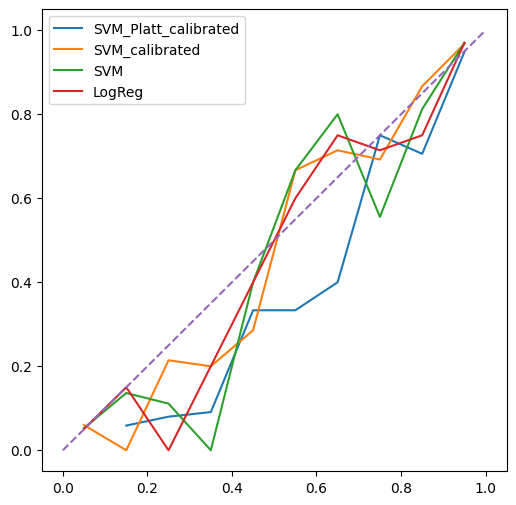

In [106]:
from sklearn.isotonic import IsotonicRegression

# class IsotonicCalibrator():

#     def __init__(self):

#         self.i_reg = None

#     def fit(self, probs: np.array = None, y_true: np.array = None):

#         self.i_reg = IsotonicRegression(out_of_bounds = 'clip')

#         self.i_reg.fit(probs, y_true, probs)

#     def transform(self, probs: np.array = None):

#         calib_probs = self.i_reg.transform(probs)

#         calib_probs[np.isnan(calib_probs)] = 0

#         return calib_probs

# Это изотоническая калибровка. Я пытался ее вначале реализовать, но почему-то на графике кривая отображается с разрывами 
    

class PlattCalibration():

    def __init__(self):

        self.i_reg = None

    def fit(self, probs: np.array = None, y_true: np.array = None):

        self.i_reg = LogisticRegression()

        self.i_reg.fit(probs.reshape(-1,1), y_true, probs)

    def transform(self, probs: np.array = None):

        calib_probs = self.i_reg.predict_proba(probs.reshape(-1, 1))

        return calib_probs


calib = PlattCalibration()
calib.fit(model_1.predict_proba(X_train)[:, 1], y_train)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))


plot_calibration_curve(y_test, calib.transform(model_1.predict_proba(X_test)[:, 1])[:, 1], ax, 'SVM_Platt_calibrated')
plot_calibration_curve(y_test, svm_calibrated.predict_proba(X_test)[:, 1], ax, 'SVM_calibrated')
plot_calibration_curve(y_test, model_1.predict_proba(X_test)[:, 1], ax, 'SVM')
plot_calibration_curve(y_test, model_2.predict_proba(X_test)[:, 1], ax, 'LogReg')
ax.plot([0, 1], [0,1], linestyle='--')
plt.legend();

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [107]:
df = pd.read_csv('bike_buyers.csv')

categorical = ['Marital Status', 'Gender', 'Children', 'Education', 'Occupation', 'Home Owner', 'Cars', 'Commute Distance', 'Region']
numerical = ['Income', 'Age']
#Заменим пропуски категориальных переменных
df[categorical] = df[categorical].fillna('undefined').astype('str')

X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

#Разделим на категориальные признаки и числовые
X_numerical = df[numerical]
X_categorical = df[categorical]

В начале поработаем только с категориальными признаками

In [108]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

In [109]:
def plot_pr(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 1, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax, name=classifier_name)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax.set_title("PRC")
  ax.set_ylim(0, 1.1)


#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

Время, потребовавшееся на обучение модели и кодирование признаков: 0.0070781707763671875 сек. 

LogReg_OrdEnc metrics
AUC-PR: 0.64678


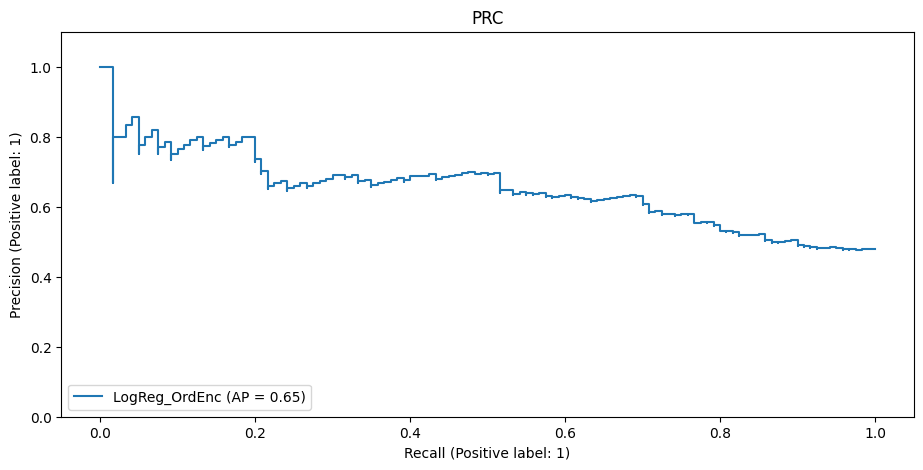

In [110]:
from sklearn.preprocessing import OrdinalEncoder
import time

log_reg = LogisticRegression()

start = time.time()

encoder = OrdinalEncoder()

encoder.fit(X_train, y_train)

X_train_OrdEnc = encoder.transform(X_train)
X_test_OrdEnc = encoder.transform(X_test)

log_reg.fit(X_train_OrdEnc, y_train)

print(f'Время, потребовавшееся на обучение модели и кодирование признаков: {time.time() - start} сек.', '\n')

plot_pr(y_test, log_reg.predict_proba(X_test_OrdEnc)[:, 1], 'LogReg_OrdEnc')

#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

Время, потребовавшееся на обучение модели и кодирование признаков: 0.01464700698852539 сек. 

Some Classifier metrics
AUC-PR: 0.70002


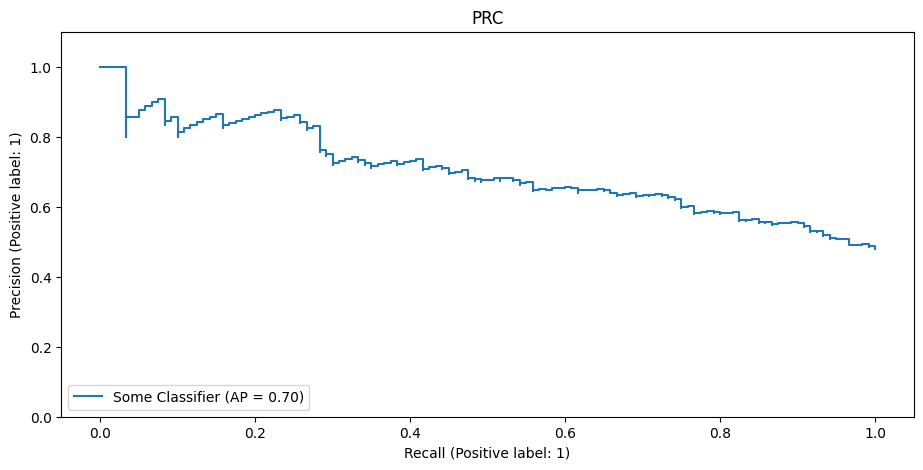

In [111]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

start = time.time()

encoder.fit(X_train, y_train)

X_train_OHE = encoder.transform(X_train)
X_test_OHE = encoder.transform(X_test)

log_reg.fit(X_train_OHE, y_train)

print(f'Время, потребовавшееся на обучение модели и кодирование признаков: {time.time() - start} сек.', '\n')

plot_pr(y_test, log_reg.predict_proba(X_test_OHE)[:, 1])

precision, recall, _ = precision_recall_curve(y_test, log_reg.predict_proba(X_test_OHE)[:, 1])
ohe_target = auc(recall, precision)

### <div style='color:red'> Вывод: </div>
#### Качество модели улучшилось, но на кодирование признаков с помощью <code>OneHotEncoder</code> ушло больше времени

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

Время, потребовавшееся на обучение модели и кодирование признаков: 0.01808619499206543 сек. 

Some Classifier metrics
AUC-PR: 0.68030


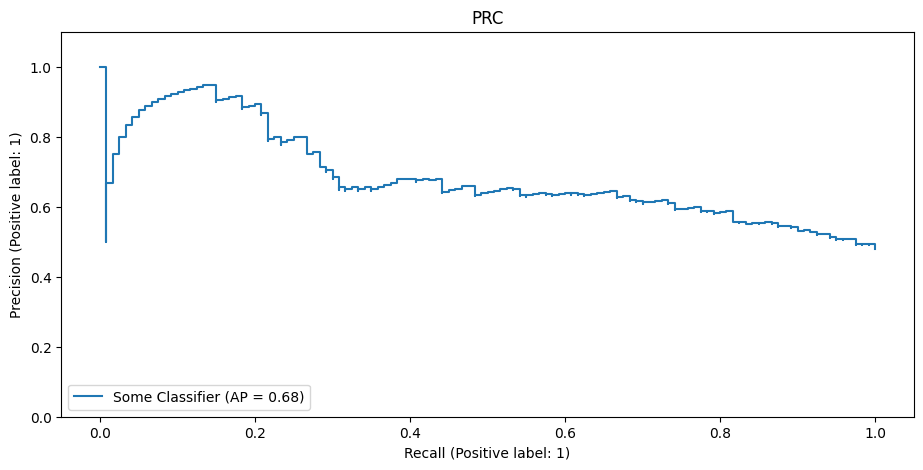

In [112]:
X_train_MTE = X_train.copy()
X_test_MTE = X_test.copy()

start = time.time()

for i in X_train.columns:

    dt = pd.concat([X_train[i], y_train], axis=1)

    dt = dt.groupby(i).agg({'Purchased Bike': 'mean'}).to_dict('dict')['Purchased Bike']

    X_train_MTE[i] = X_train_MTE[i].replace(dt)
    X_test_MTE[i] = X_test_MTE[i].replace(dt)

log_reg.fit(X_train_MTE, y_train)

print(f'Время, потребовавшееся на обучение модели и кодирование признаков: {time.time() - start} сек.', '\n')

plot_pr(y_test, log_reg.predict_proba(X_test_MTE)[:, 1])



precision, recall, thresholds = precision_recall_curve(y_test, log_reg.predict_proba(X_test_MTE)[:, 1])
mte_pr_target = auc(recall, precision)

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

Some Classifier metrics
AUC-PR: 0.68030


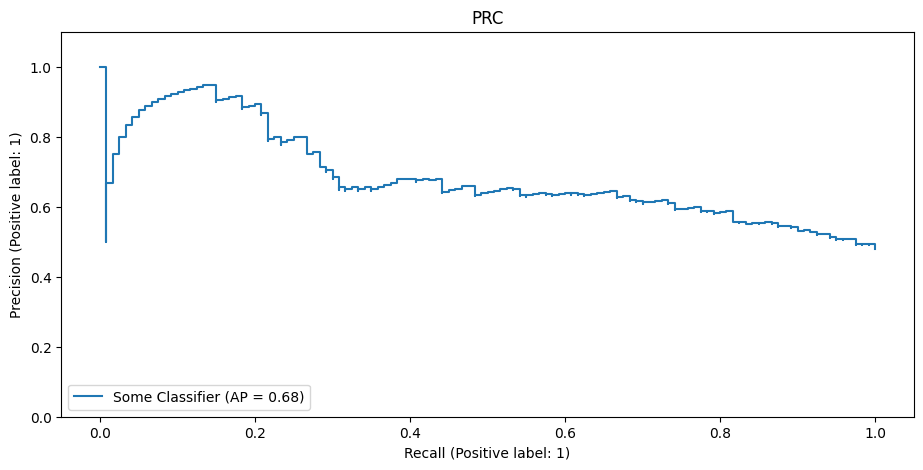

In [113]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, feat_columns: np.array = None):

        self.feat_columns = feat_columns

    def fit(self, X: np.array = None, y: np.array = None, C: int = 0, global_mean: int = None):

        if self.feat_columns is None:
            self.feat_columns = X.columns
        
        if C == 0:  

            table = pd.concat([X, y], axis=1)

            melted_df = table.melt(id_vars=table.columns[-1], value_vars=X.columns, value_name='value')

            calcs = melted_df.groupby(['variable', 'value']).agg({f'{table.columns[-1]}': 'mean'}).reset_index()

    

        else:

            table = pd.concat([X, y], axis=1)

            if global_mean is None:
                global_mean = y.mean()

            melted_df = table.melt(id_vars=table.columns[-1], value_vars=X.columns, value_name='value')

            calcs = melted_df.groupby(['variable', 'value']).agg({f'{table.columns[-1]}': 'sum', 'variable':'count'})

            calcs[table.columns[-1]] += C * global_mean
            calcs['variable'] += C

            calcs[f'{table.columns[-1]}'] = calcs[f'{table.columns[-1]}'] / calcs['variable']

            calcs = calcs.drop(['variable'], axis=1).reset_index()


        calcs['new_value'] = calcs['variable'] + '_' + calcs['value'].astype('str')

        self.new_calcs = calcs[['new_value', 'Purchased Bike']].set_index('new_value').to_dict()[table.columns[-1]]


    
    def transform(self, X: pd.DataFrame = None):

        matt = np.tile(X.columns, (X.shape[0], 1))

        new_df = (matt + '_' + X.astype('str')).replace(self.new_calcs)

        return new_df

encoder = MeanTargetEncoder()

encoder.fit(X_train, y_train)
X_train_MTE = encoder.transform(X_train)
X_test_MTE = encoder.transform(X_test)

log_reg.fit(X_train_MTE, y_train)

plot_pr(y_test, log_reg.predict_proba(X_test_MTE)[:, 1])

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

Some Classifier metrics
AUC-PR: 0.70749


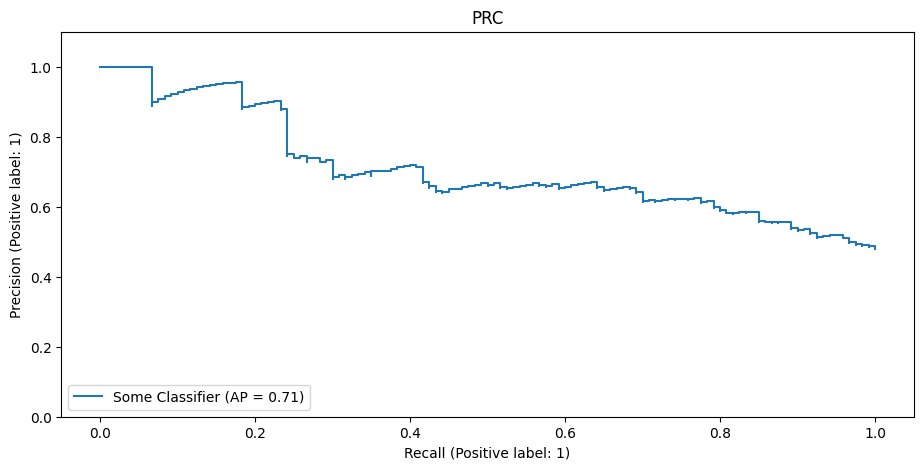

In [114]:
mus = np.linspace(0, 0.5, 100)
stds = np.linspace(0, 0.3, 100)

encoder = MeanTargetEncoder()
encoder.fit(X_train, y_train)

X_train_MTE_n = encoder.transform(X_train)
X_test_MTE_n = encoder.transform(X_test)

best_preds = None

for mu in mus:
    for std in stds:

        X_train_MTE_add_noise = X_train_MTE_n.copy()

        epsilon = np.random.normal(mu, std, (X_train_MTE_n.shape[0], X_train_MTE_n.shape[1]))

        X_train_MTE_add_noise += epsilon

        log_reg.fit(X_train_MTE_add_noise, y_train)

        ### PR-AUC на обучающей выборке
        precision, recall, thresholds = precision_recall_curve(y_train, log_reg.predict_proba(X_train_MTE_add_noise)[:, 1])
        auc_precision_recall_on_train = auc(recall, precision)

        ### PR-AUC на тестовой выборке
        precision, recall, thresholds = precision_recall_curve(y_test, log_reg.predict_proba(X_test_MTE_n)[:, 1])
        auc_precision_recall_on_test = auc(recall, precision)

        ### Установил порог 0.08, который будет ограничивать переобучение
        if auc_precision_recall_on_test > mte_pr_target and auc_precision_recall_on_test < auc_precision_recall_on_train + 0.08:
            mte_pr_target = auc_precision_recall_on_test
            best_preds = log_reg.predict_proba(X_test_MTE_n)[:, 1]
        
plot_pr(y_test, best_preds)


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Добавление шумов действительно помогло, поскольку позволяет немного сбалансировать категории, т.е. увеличиваются значения у категорий с низким средним это значение становится чуть более весомым в данных 

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [115]:
#your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


Лучшее C: 97.14285714285714
Лучшее global_mean: 0.04040404040404041 

Some Classifier metrics
AUC-PR: 0.72908


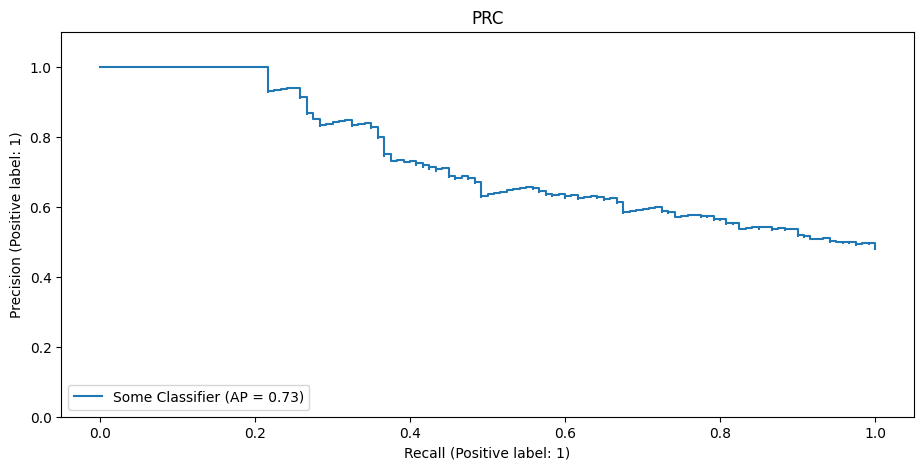

In [116]:
def mte_with_smooth(X_train, X_test, y, C, glob_mean):

    for i in X_train.columns:
        
        dt = pd.concat([X_train[i], y_train], axis=1)
        dt = dt.groupby(i).agg({i:'count', 'Purchased Bike':'sum'})
        dt['Purchased Bike'] += C * glob_mean
        dt[i] += C

        dt['Purchased Bike'] /= dt[i]
        dt = dt.drop(i, axis=1).to_dict()['Purchased Bike']

        X_train[i] = X_train[i].replace(dt)
        X_test[i] = X_test[i].replace(dt)

    return X_train, X_test

C = np.linspace(-10, 200, 50)
global_means = np.linspace(0, 1, 100)

best_score = ohe_target
best_pred = None

best_c = 0
best_glob_mean = 0

for c in C:
    for glb_mn in global_means:

        X_train_mt, X_test_mt = mte_with_smooth(X_train, X_test, y_train, c, glb_mn)

        log_reg.fit(X_train_mt, y_train)
        
        precision, recall, thresholds = precision_recall_curve(y_test, log_reg.predict_proba(X_test_mt)[:, 1])
        auc_precision_recall = auc(recall, precision)

        if auc_precision_recall > best_score:

            best_score = auc_precision_recall
            best_pred = log_reg.predict_proba(X_test_mt)[:, 1]
            best_c = c
            best_glob_mean = glb_mn

print(f'Лучшее C: {best_c}')
print(f'Лучшее global_mean: {best_glob_mean}', '\n')

plot_pr(y_test, best_pred)


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [117]:
X_numerical = X_numerical.fillna(X_numerical.mean(axis=0), axis=0)

X_train_cat, X_test_cat, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)
X_train_num, X_test_num, y_train, y_test = train_test_split(X_numerical, y, test_size=0.25, random_state=777, stratify=y)

In [118]:
print('Количество уникальных значений у числовых признаков')

X_numerical.nunique()

Количество уникальных значений у числовых признаков


Income    17
Age       54
dtype: int64

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

In [119]:
results_of_encoding = pd.DataFrame(columns = list(X_numerical.columns.values) + ['PR-AUC-score'])

encoder = MeanTargetEncoder()

X_train_cat_mte = X_train_cat.copy()
X_test_cat_mte = X_test_cat.copy()

X_train_num_mte = X_train_num.copy()
X_test_num_mte = X_test_num.copy()

encoder.fit(X_train_cat_mte, y_train)

X_train_cat_mte = encoder.transform(X_train_cat_mte)
X_test_cat_mte = encoder.transform(X_test_cat_mte)


for i in range(len(X_train_num.columns)):
    
    isEncoded = [False] * len(X_train_num.columns)

    isEncoded[i] = True

    X_train_num_enc = X_train_num.copy()
    X_test_num_enc = X_test_num.copy()

    dt = pd.DataFrame(X_train_num[X_train_num.columns[i]])

    encoder.fit(dt, y_train)

    X_train_num_enc[X_train_num.columns[i]] = encoder.transform(pd.DataFrame(X_train_num[X_train_num.columns[i]]))
    X_train_num_enc[X_train_num.columns[i]] = encoder.transform(pd.DataFrame(X_train_num[X_train_num.columns[i]]))


    X_tr = pd.concat([X_train_num_enc, X_train_cat_mte], axis=1)
    X_tst = pd.concat([X_test_num_enc, X_test_cat_mte], axis=1)
    
    log_reg.fit(X_tr, y_train)

    precision, recall, thresholds = precision_recall_curve(y_test, log_reg.predict_proba(X_tst)[:, 1])
    auc_precision_recall = auc(recall, precision)

    new_data = pd.DataFrame([isEncoded + [auc_precision_recall]], columns = results_of_encoding.columns)

    results_of_encoding = pd.concat([results_of_encoding, new_data], axis=0)


encoder.fit(X_train_num_mte, y_train)

X_train_num_mte = encoder.transform(X_train_num_mte)
X_test_num_mte = encoder.transform(X_test_num_mte)

X_tr = pd.concat([X_train_num_mte, X_train_cat_mte], axis=1)
X_tst = pd.concat([X_test_num_mte, X_test_cat_mte], axis=1)

log_reg.fit(X_tr, y_train)

precision, recall, thresholds = precision_recall_curve(y_test, log_reg.predict_proba(X_tst)[:, 1])
auc_precision_recall = auc(recall, precision)

new_data = pd.DataFrame([[True, True] + [auc_precision_recall]], columns = results_of_encoding.columns)
results_of_encoding = pd.concat([results_of_encoding, new_data], axis=0)

results_of_encoding

,Income,Age,PR-AUC-score
0,True,False,0.740000
0,False,True,0.410759
0,True,True,0.662933


_**Ответ:**_ Кодирование признака <code>Income</code> улучшило модель, что нельзя сказать о кодировании других признаков

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ Плюсы <code>MeanTargetEncoder</code>:

- #### Не создаются новые признаки, поэтому матрица не будет разреженной

- #### Учитывается взаимосвязь с таргетом

- #### Лучше работает с редкими категориями


# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [120]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

zsh:1: command not found: wget


In [121]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
11683,47,Self-emp-not-inc,177457,Some-college,10,Married-civ-spouse,Other-service,Husband,Black,Male,0,0,40,United-States,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [122]:
y = df.income
X = df.drop('income', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [123]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
numeric = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('other', 'passthrough', numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression())
])

model = pipeline.fit(X_train, y_train)

print(f'Количество новых признаков: {len(column_transformer.named_transformers_["ohe"].get_feature_names_out()) - len(numeric)}')

Количество новых признаков: 96


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

Some Classifier metrics
AUC-PR: 0.45033


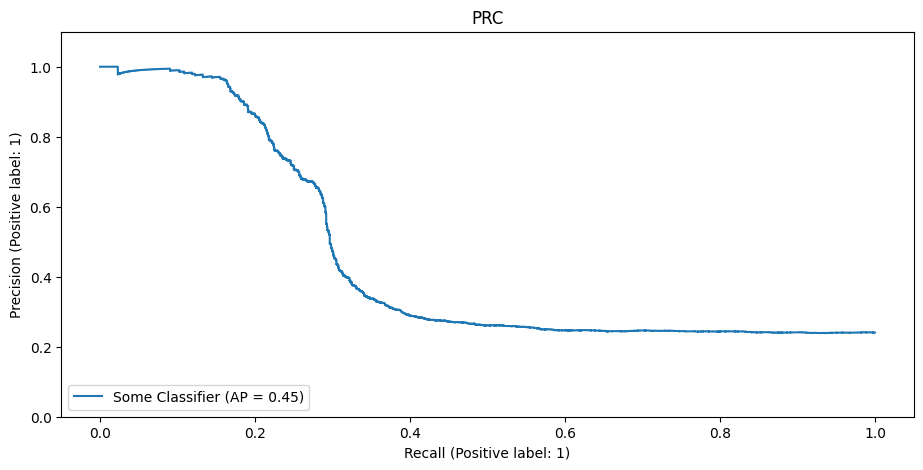

In [124]:
plot_pr(y_test, model.predict_proba(X_test)[:, 1])

#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



Время, затраченное на отбор признаков: 0.0008499622344970703 сек.
Some Classifier metrics
AUC-PR: 0.71437


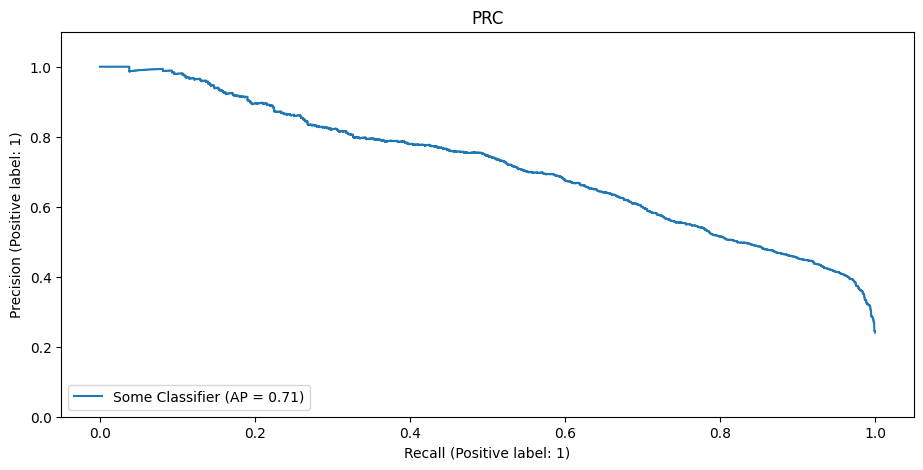

In [125]:
start = time.time()

feat_names = column_transformer.get_feature_names_out()
coefs = abs(model.named_steps['regression'].coef_.ravel())

features = pd.DataFrame({'Features': feat_names, 'Coefs': coefs})
features = features.sort_values('Coefs', ascending=False)
top_40_feats = features['Features'].values[:40]

print(f'Время, затраченное на отбор признаков: {time.time() - start} сек.')

X_tr = pd.DataFrame(column_transformer.fit_transform(X_train, y_train).toarray(), columns=feat_names)
X_tst = pd.DataFrame(column_transformer.transform(X_test).toarray(), columns=feat_names)

X_tr = X_tr[top_40_feats]
X_tst = X_tst[top_40_feats]

log_reg.fit(X_tr, y_train)

plot_pr(y_test, log_reg.predict_proba(X_tst)[:, 1])


Изменилось ли качество? Как?

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

Some Classifier metrics
AUC-PR: 0.74388


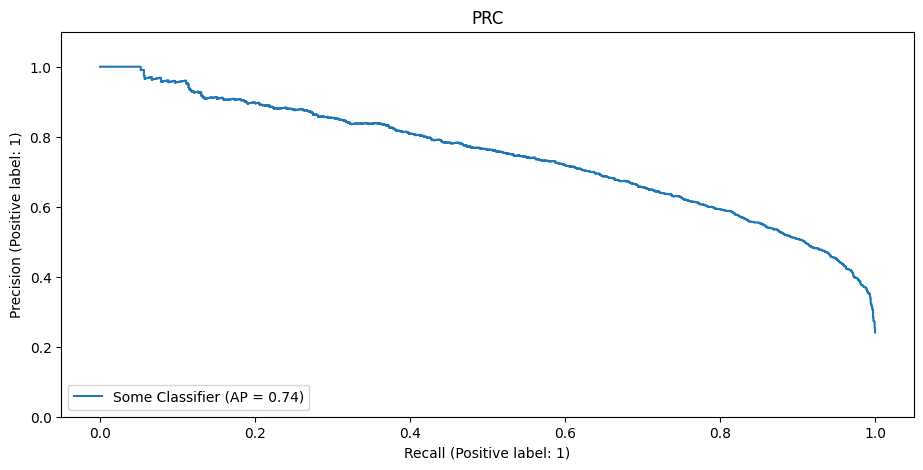

In [126]:
from sklearn.preprocessing import MinMaxScaler

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaler', MinMaxScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression())
])

model = pipeline.fit(X_train, y_train)

feat_names = column_transformer.get_feature_names_out()
coefs = abs(model.named_steps['regression'].coef_.ravel())

features = pd.DataFrame({'Features': feat_names, 'Coefs': coefs})
features = features.sort_values('Coefs', ascending=False)
top_40_feats = features['Features'].values[:40]


X_tr = pd.DataFrame(column_transformer.fit_transform(X_train, y_train).toarray(), columns=feat_names)
X_tst = pd.DataFrame(column_transformer.transform(X_test).toarray(), columns=feat_names)

X_tr = X_tr[top_40_feats]
X_tst = X_tst[top_40_feats]

log_reg.fit(X_tr, y_train)

plot_pr(y_test, log_reg.predict_proba(X_tst)[:, 1])

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

Some Classifier metrics
AUC-PR: 0.76109


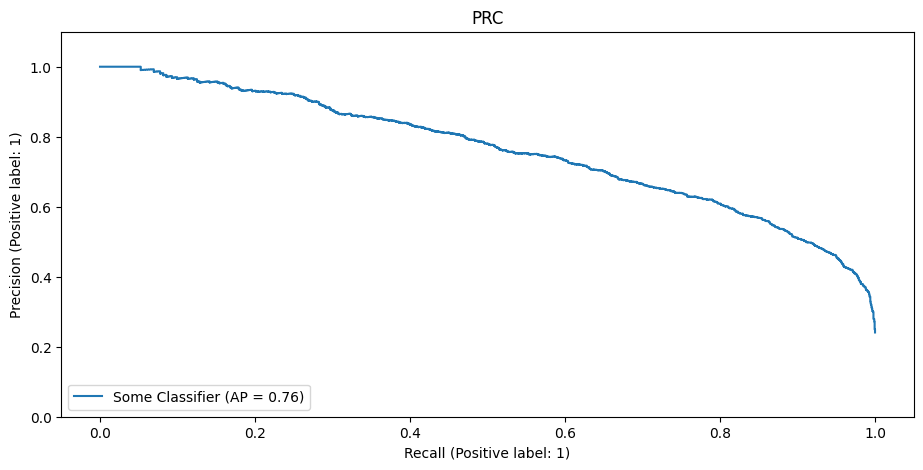

In [127]:
from sklearn.preprocessing import StandardScaler

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('other', 'passthrough', numeric)
])

pipeline = Pipeline(steps=[
    ('regression', LogisticRegression())
])

encoder = StandardScaler()

X_tr = pd.DataFrame(column_transformer.fit_transform(X_train, y_train).toarray(), columns=column_transformer.get_feature_names_out())
X_tst = pd.DataFrame(column_transformer.transform(X_test).toarray(), columns=column_transformer.get_feature_names_out())

X_tr = pd.DataFrame(encoder.fit_transform(X_tr, y_train), columns=column_transformer.get_feature_names_out())
X_tst = pd.DataFrame(encoder.transform(X_tst), columns=column_transformer.get_feature_names_out())

model = pipeline.fit(X_tr, y_train)
coefs = abs(model.named_steps['regression'].coef_.ravel())

dt = pd.DataFrame({'Feature': column_transformer.get_feature_names_out(), 'Coefs':coefs})
dt = dt.sort_values('Coefs', ascending=False)

top_40_feats = dt['Feature'].values[:40]

X_tr = X_tr[top_40_feats]
X_tst = X_tst[top_40_feats]

log_reg.fit(X_tr, y_train)

plot_pr(y_test, log_reg.predict_proba(X_tst)[:, 1])

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



Время, потребовавшееся на обучение модели и кодирование признаков: 0.45864200592041016 сек. 

Some Classifier metrics
AUC-PR: 0.64930


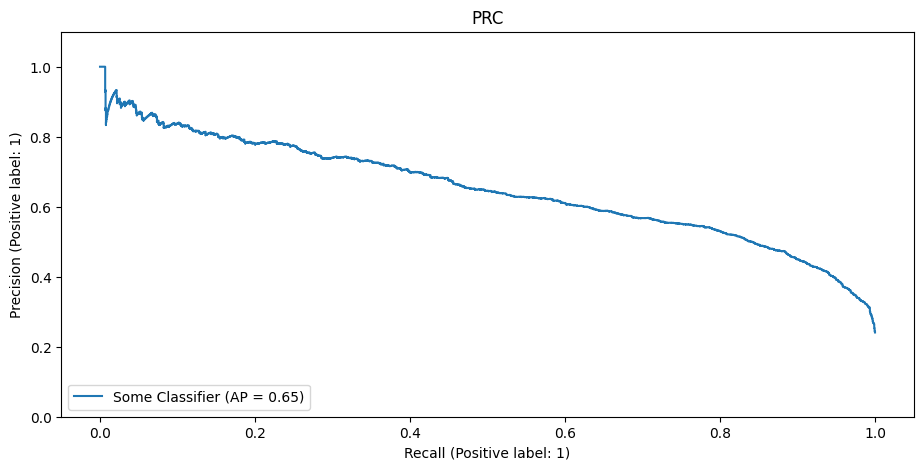

In [128]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaler', StandardScaler(), numeric)
])

X_tr = pd.DataFrame(column_transformer.fit_transform(X_train).toarray(), columns=column_transformer.get_feature_names_out())
X_tst = pd.DataFrame(column_transformer.transform(X_test).toarray(), columns=column_transformer.get_feature_names_out())

t_statistics = []

start = time.time()

for i in X_tr.columns:

    dt = pd.concat([X_tr[i], y_train], axis=1)

    dt = dt.groupby('income').agg({i:['mean', 'count', 'var']}).reset_index()

    p_mean, p_count, p_var = dt[dt.income == 1].values[:, 1:][0]
    n_mean, n_count, n_var = dt[dt.income == 0].values[:, 1:][0]

    t = abs(p_mean - n_mean) / (np.sqrt((p_count * p_var + n_count * n_var)/(p_count + n_count)))

    if np.isnan(t):
        t = 0

    t_statistics.append(t)

dt = pd.DataFrame({'Feature': column_transformer.get_feature_names_out(), 't_stat': t_statistics}).sort_values('t_stat', ascending=False)
top_40_feats = dt['Feature'].values[:40]

print(f'Время, потребовавшееся на обучение модели и кодирование признаков: {time.time() - start} сек.', '\n')

X_tr = X_tr[top_40_feats]
X_tst = X_tst[top_40_feats]

log_reg.fit(X_tr, y_train)

plot_pr(y_test, log_reg.predict_proba(X_tst)[:, 1])

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

Время, потребовавшееся на обучение модели и кодирование признаков: 3540.580065011978 мин. 

Some Classifier metrics
AUC-PR: 0.76159


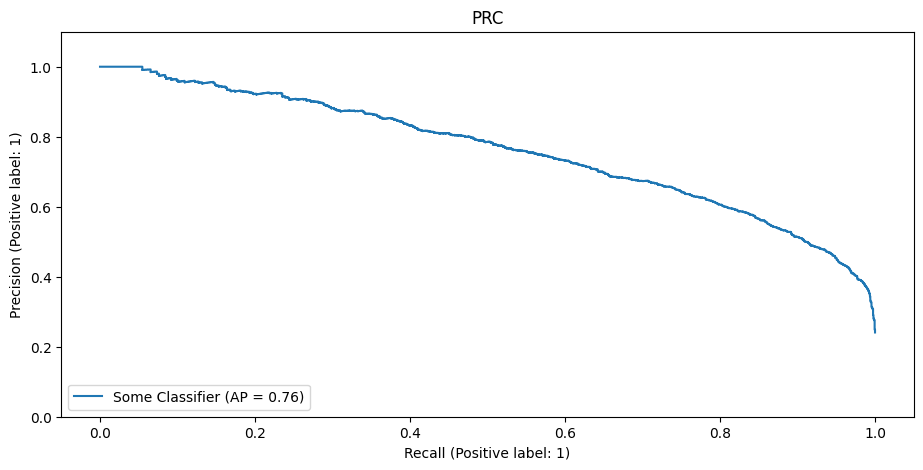

In [129]:
X_tr = pd.DataFrame(column_transformer.fit_transform(X_train).toarray(), columns=column_transformer.get_feature_names_out())
X_tst = pd.DataFrame(column_transformer.transform(X_test).toarray(), columns=column_transformer.get_feature_names_out())

X_tr_1, X_tr_2, y_tr_1, y_tr_2 = train_test_split(X_tr, y_train, test_size=0.2, stratify = y_train)

start = time.time()

while X_tr_1.shape[1] > 40:

    best_score = 0
    worst_feature = None

    for i in X_tr_1.columns:

        X_tr_1_copy = X_tr_1.copy()
        X_tr_2_copy = X_tr_2.copy()

        X_tr_1_copy = X_tr_1_copy.drop(i, axis=1)
        X_tr_2_copy = X_tr_2_copy.drop(i, axis=1)

        log_reg.fit(X_tr_1_copy, y_tr_1)

        
        precision, recall, thresholds = precision_recall_curve(y_tr_2, log_reg.predict_proba(X_tr_2_copy)[:, 1])
        auc_precision_recall = auc(recall, precision)

        if auc_precision_recall > best_score:

            best_score = auc_precision_recall
            worst_feature = i

    X_tr_1 = X_tr_1.drop(worst_feature, axis=1)
    X_tr_2 = X_tr_2.drop(worst_feature, axis=1)

print(f'Время, потребовавшееся на обучение модели и кодирование признаков: {time.time() - start} мин.', '\n')

X_tr = X_tr[X_tr_1.columns]
X_tst = X_tst[X_tr_1.columns]

log_reg.fit(X_tr, y_train)

plot_pr(y_test, log_reg.predict_proba(X_tst)[:, 1])

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

Время, потребовавшееся на обучение модели и кодирование признаков: 1575.3340981006622 мин. 

Some Classifier metrics
AUC-PR: 0.70893


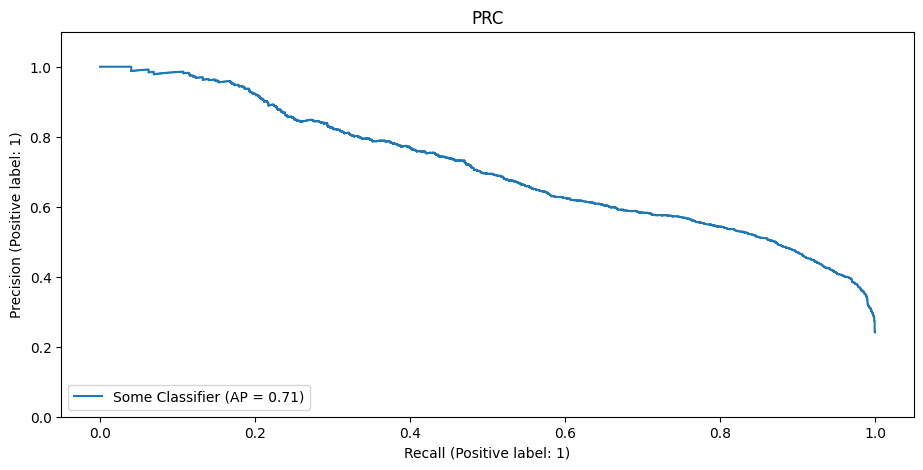

In [130]:
X_tr = pd.DataFrame(column_transformer.fit_transform(X_train).toarray(), columns=column_transformer.get_feature_names_out())
X_tst = pd.DataFrame(column_transformer.transform(X_test).toarray(), columns=column_transformer.get_feature_names_out())

X_tr_1, X_tr_2, y_tr_1, y_tr_2 = train_test_split(X_tr, y_train, test_size=0.2, stratify = y_train)

start = time.time()

top_features = []

while len(top_features) < 40:

    worst_score = np.inf
    best_feature = None

    for i in X_tr_1.columns:

        X_tr_1_copy = X_tr_1.copy()
        X_tr_2_copy = X_tr_2.copy()

        X_tr_1_copy = X_tr_1_copy.drop(i, axis=1)
        X_tr_2_copy = X_tr_2_copy.drop(i, axis=1)

        log_reg.fit(X_tr_1_copy, y_tr_1)

        
        precision, recall, thresholds = precision_recall_curve(y_tr_2, log_reg.predict_proba(X_tr_2_copy)[:, 1])
        auc_precision_recall = auc(recall, precision)

        if auc_precision_recall < worst_score:

            worst_score = auc_precision_recall
            best_feature = i

    X_tr_1 = X_tr_1.drop(best_feature, axis=1)
    X_tr_2 = X_tr_2.drop(best_feature, axis=1)

    top_features.append(best_feature)

print(f'Время, потребовавшееся на обучение модели и кодирование признаков: {time.time() - start} мин.', '\n')

X_tr = X_tr[top_features]
X_tst = X_tst[top_features]

log_reg.fit(X_tr, y_train)

plot_pr(y_test, log_reg.predict_proba(X_tst)[:, 1])

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:**

- #### **T-статистика:** Показала наихудший результат, возможно из-за жестких округлений, поскольку для некоторых значений статистика была NaN из-за того, что дисперсия была очень маленькой, но отображалась как 0

- #### **Отсечение по одному признаку** Показала наилучший результат. Это связано с тем, что мы отбрасывали самые "слабые" признаки, таким образом у нас оставалась группа сильных признаков и поэтому в итоге выдало лучшее качество

- #### **Добавление по одному признаку** Хоть этот метод и противоположен отсечению по одному признаку, но тем не менее качество получилось чуть-хуже. Я предполагаю, что это связано с тем, что мы с каждой новой итерацией выкидывали самый полезный признак. Стоит учесть еще тот факт, что маловероятно, что все признаки линейно независимы, поэтому отбрасывание сильных признаков может повлечь за собой важность других признаков

#### upd. На графиках указано время работы в минутах, не успел исправить, там в секундах

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [131]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
# !unzip bank-additional.zip
df = pd.read_csv('/Users/vsevolodparamonov/Downloads/bank-additional/bank-additional-full.csv', sep=';')

In [132]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [133]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [134]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=500)

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [135]:
categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numeric = ['age', 'pdays', 'campaign', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

preds = dict()

i = 0

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaler', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression())
])

for train_idx, test_idx in kf.split(X,y):

    X_train = X.loc[train_idx]
    y_train = y.loc[train_idx]

    X_test = X.loc[test_idx]
    y_test = y.loc[test_idx]

    model = pipeline.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    preds[i] = y_pred

    i+=1 

Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [136]:
j = 0

profit = []
call_center = []

for train_idx, test_idx in kf.split(X,y):

    y_test = y.loc[test_idx].values

    rights = ((preds[j] == y_test) & (y_test == 1) & (preds[j] == 1))
    
    rights = rights.sum()

    profit.append(rights * 10 - sum(preds[j]))

    call_center.append(sum(preds[j]))


    j += 1

print(f'Средняя прибыль {np.mean(profit)}')
print(f'Стандартное отклонение: {np.std(profit)}')
print(f'Средняя сумма, которую придется отдать операторам: {np.mean(call_center)}', '\n')

Средняя прибыль 1797.4
Стандартное отклонение: 107.65240359601823
Средняя сумма, которую придется отдать операторам: 322.6 



Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [137]:
j = 0

profit = []
call_center = []

for train_idx, test_idx in kf.split(X,y):

    y_test = y.loc[test_idx].values

    rights = ((preds[j] == y_test) & (y_test == 1) & (preds[j] == 1))

    money = np.random.uniform(0, 20, len(rights))

    rights = rights * money
    
    rights = rights.sum()

    profit.append(rights - sum(preds[j]))

    call_center.append(sum(preds[j]))


    j += 1

print(f'Средняя прибыль {np.mean(profit)}')
print(f'Стандартное отклонение: {np.std(profit)}')
print(f'Средняя сумма, которую придется отдать операторам: {np.mean(call_center)}', '\n')

Средняя прибыль 1770.6030566317008
Стандартное отклонение: 134.80544408050454
Средняя сумма, которую придется отдать операторам: 322.6 



Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

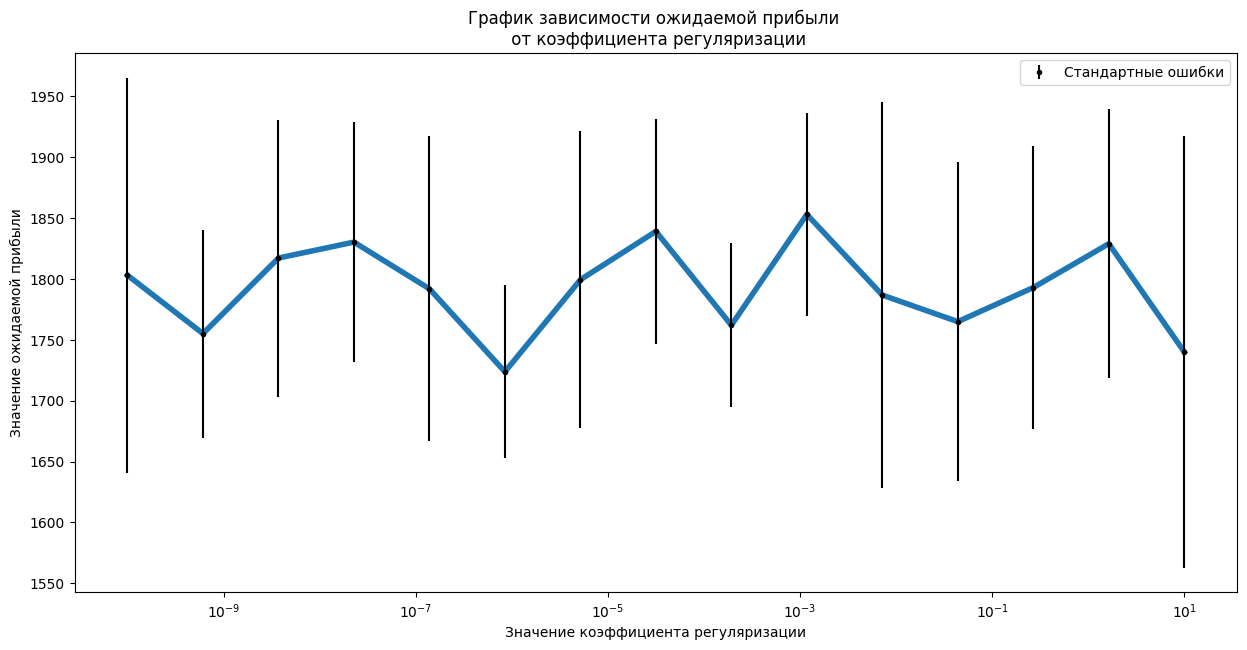

In [138]:
lambdas = np.logspace(-10, 1, 15)

mean_profit = []
error = []

for l in lambdas:


    column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaler', StandardScaler(), numeric)
    ])

    pipeline = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', LogisticRegression(C=l))
    ])

    j = 0

    profit = []
    call_center = []
    errs = []

    for train_idx, test_idx in kf.split(X,y):

        y_test = y.loc[test_idx].values

        rights = ((preds[j] == y_test) & (y_test == 1) & (preds[j] == 1))

        money = np.random.uniform(0, 20, len(rights))

        rights = rights * money
        
        rights = rights.sum()

        profit.append(rights - sum(preds[j]))

        j += 1

    mean_profit.append(np.mean(profit))
    error.append(np.std(profit))


fig, ax = plt.subplots(1, figsize=(15, 7))



ax.plot(lambdas, mean_profit, linewidth=4)
ax.set_xlabel('Значение коэффициента регуляризации')
ax.set_ylabel('Значение ожидаемой прибыли')
ax.set_title('График зависимости ожидаемой прибыли \n от коэффициента регуляризации')
ax.set_xscale('log')

ax.errorbar(lambdas, mean_profit, yerr=error, fmt='.k', label='Стандартные ошибки')
ax.legend();




Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

### <div style='color:red'> Ответ: </div>
#### Наличие регуляризации однозначно влияет на среднее значение ожидаемой прибыли. Закономерности не обнаружены, поскольку в формуле расчета прибыли есть равномерно распределенная случайная величина, которая влияет на значения прибыли, таким образом исключая возможность адекватного оценивания эффективности применения регуляризации

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ Для нашей задачи важнее <code>precision</code> поскольку нам важна точность каждого прогноза из-за того, что за каждый звонок менеджеру платятся деньги. Если бы <code>recall</code> был важнее, то прибыль была бы вероятнее всего меньше



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [139]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaler', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression())
])

mean_profit = []
errors = []

max_mean_profit = 0
best_t = 0


# threshold = np.arange(0, 1, 0.01)
threshold = np.arange(0, 1, 0.01)

j = 0

for t in threshold:

    profit = []

    for train_idx, test_idx in kf.split(X,y):

        X_train = X.loc[train_idx]
        y_train = y.loc[train_idx]

        X_test = X.loc[test_idx]
        y_test = y.loc[test_idx].values

        model = pipeline.fit(X_train, y_train)
        preds = model.predict_proba(X_test)

        preds = np.apply_along_axis(lambda x: 1 if x[1] > t else 0, 1, preds)


        rights = ((preds == y_test) & (y_test == 1) & (preds == 1))
        
        money = np.random.uniform(0, 20, len(rights))

        rights = rights * money

        rights = rights.sum()

        profit.append(rights - sum(preds))

        j += 1

    mean_profit.append(np.mean(profit))
    errors.append(np.std(profit))

    if np.mean(profit) > max_mean_profit:
        max_mean_profit = np.mean(profit)
        best_t = t

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




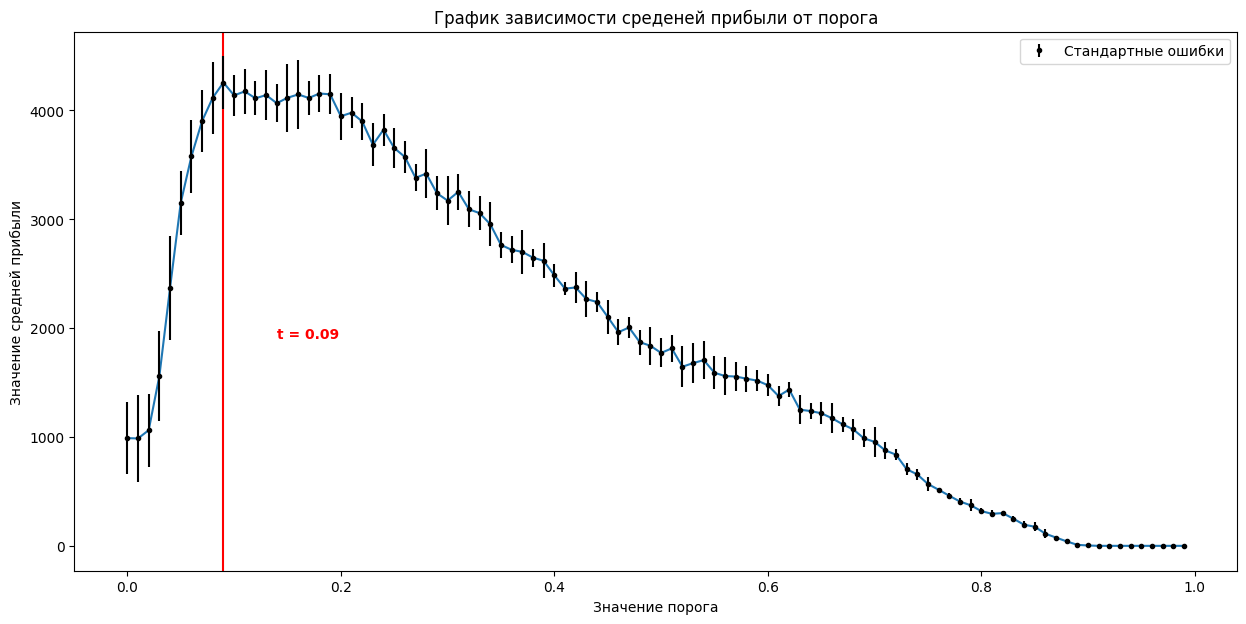

In [140]:
fig, ax = plt.subplots(1, figsize=(15, 7))


ax.plot(threshold, mean_profit)
ax.set_xlabel('Значение порога')
ax.set_ylabel('Значение средней прибыли')
ax.set_title('График зависимости среденей прибыли от порога')
ax.axvline(x=best_t, color='red')
ax.text(x=best_t + 0.05, y=np.mean(mean_profit), s=f't = {best_t}', weight='bold', color='red')
ax.errorbar(threshold, mean_profit, yerr=errors, fmt='.k', label='Стандартные ошибки')
ax.legend();

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ Значение порога колеблется в рамках значения 0.1, что может быть связано с экономической интерпретацией (предельные издержки и тд.)

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [141]:
from sklearn.metrics import precision_score, recall_score

precisions = []
recalls = []

for train_idx, test_idx in kf.split(X,y):

    X_train = X.loc[train_idx]
    y_train = y.loc[train_idx]

    X_test = X.loc[test_idx]
    y_test = y.loc[test_idx].values

    model = pipeline.fit(X_train, y_train)
    preds = model.predict_proba(X_test)

    preds = np.apply_along_axis(lambda x: 1 if x[1] > best_t else 0, 1, preds)

    precisions.append(precision_score(y_test, preds))
    recalls.append(recall_score(y_test, preds))

print(f'Средний precision: {np.mean(precisions)}')
print(f'Стандартное отклонение precision: {np.std(precisions)}', '\n')

print(f'Средний recall: {np.mean(recalls)}')
print(f'Стандартное отклонение recall: {np.std(recall)}')

Средний precision: 0.29315657886711544
Стандартное отклонение precision: 0.010564113938583463 

Средний recall: 0.6773049611774324
Стандартное отклонение recall: 0.28932751482874763


Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [142]:
model = pipeline.fit(X_train, y_train)
preds = model.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, preds)

pr_auc = auc(recall, precision)

prec = precision[recall >= 0.5]
rec = recall[recall >= 0.5]

pr_auc_2 = auc(rec, prec)

print(pr_auc_2 / pr_auc)


0.30538164567786014


__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ #your answer here